In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

# Data 

In [2]:
FolderNames = ["BoulangeriePatisserie", "GlacesSorbets", "Fromage", "Electricite","Trefilage"]

df = pd.read_csv(
   "./{}/valeurs_mensuelles.csv".format(FolderNames[0]),
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
df.columns = [FolderNames[0],"ToDelete"]
del(df["ToDelete"])


for i,name in enumerate(FolderNames):
    if i>0:
        temp = pd.read_csv(
       "./{}/valeurs_mensuelles.csv".format(name),
        sep=";",
        skiprows=[1, 2],
        index_col="Libellé",
        parse_dates=["Libellé"])
        temp.columns = [FolderNames[i],"ToDelete"]
        del(temp["ToDelete"])
        df = pd.merge(df, temp, on='Libellé')
    
df.head()


,BoulangeriePatisserie,GlacesSorbets,Fromage,Electricite,Trefilage
Libellé,,,,,
2019-01-01,104.01,87.15,98.24,141.17,79.42
2018-12-01,95.64,37.26,95.97,123.86,55.01
2018-11-01,102.27,59.06,97.25,111.67,80.52
2018-10-01,111.41,65.15,98.34,91.65,87.86
2018-09-01,99.68,77.15,90.37,79.35,75.64


# Plots

Les indices de dates sont les mêmes, on peut donc merger les 5 séries sur les dates.

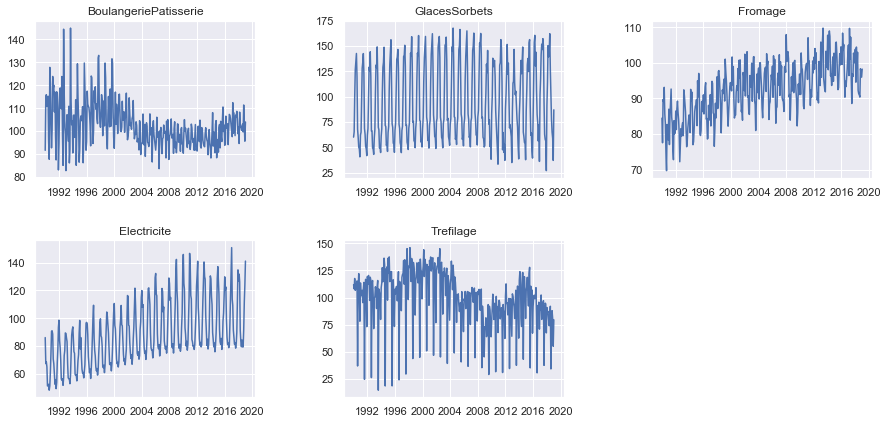

In [3]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,name in enumerate(FolderNames):
    
    X = df.iloc[:,i].dropna()
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(X)
    ax.set(title=name)

On garde la série le commerce d'electricité. Tendance croissante qui s'applatit (deux phases ?), saisonnalité annuelle évidente, et un peu d'hétéroscédascticité.

# Commerce d'éléctricité

In [3]:
dfE = pd.read_csv(
   "./Electricite/valeurs_mensuelles.csv",
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
dfE.columns = ["Electricite","ToDelete"]
del(dfE["ToDelete"])

In [4]:
len(dfE)
#12*(2019-1990)+2 = 350 

350

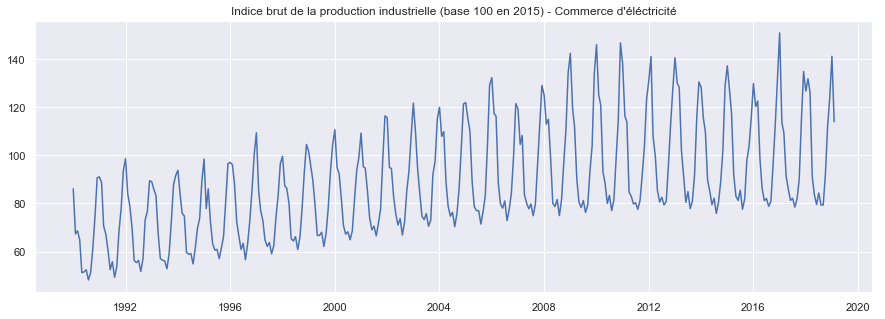

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dfE)
# u"" pour présiser qu'il s'agit une chaine de caracteres unicode pour matplotlib
plt.title(u"Indice brut de la production industrielle (base 100 en 2015) - Commerce d'éléctricité")
plt.show()

## Transformation logarithmique

In [5]:
log_dfE = np.log(dfE)

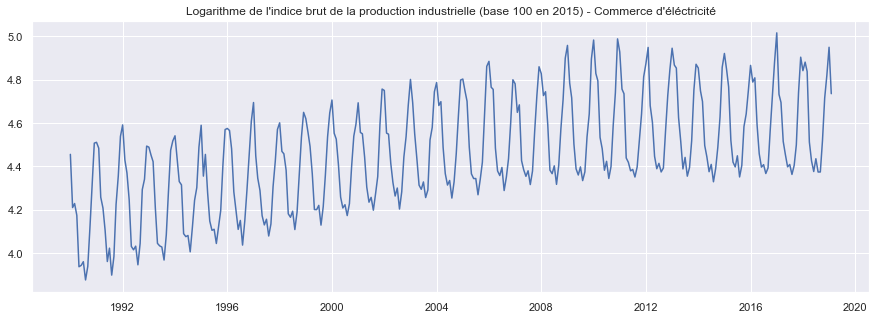

In [8]:
plt.figure(figsize=(15,5))
plt.plot(log_dfE)
plt.title(u"Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Commerce d'éléctricité")
plt.show()

**Commentaires:** La transformation logarithmique permet de corriger certaines formes d'hétéroscédasticité ou de non-linéarité. Dans notre cas, notre série était légèrement hétéroscédastique et la transformation logarithmique a permis de la corriger.<br><br>

On travaillera donc sur  la transformation logarithmique.

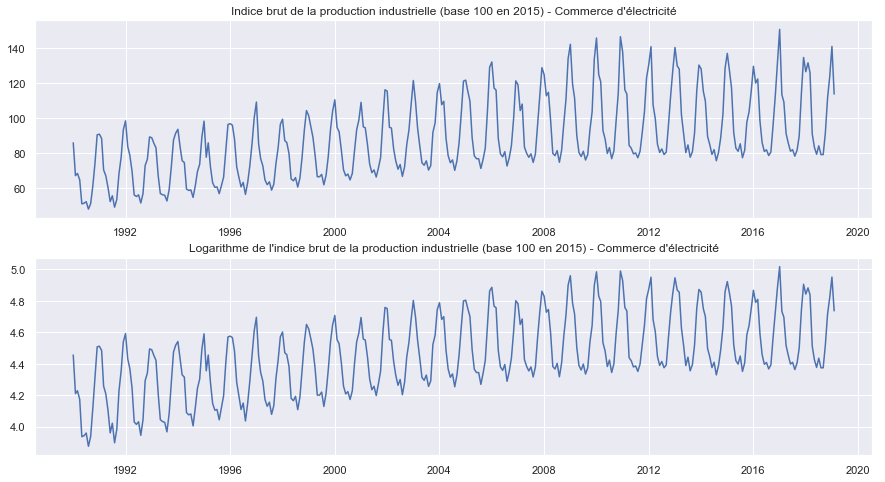

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(2, 1, 1)
plt.plot(dfE)
plt.title(u"Indice brut de la production industrielle (base 100 en 2015) - Commerce d'électricité")
#plt.ylabel, plt/xlabel

plt.subplot(2, 1, 2)
plt.plot(log_dfE)
plt.title(u"Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Commerce d'électricité")

plt.savefig("Images/donneesEtdonneesLog.png")

plt.show()

## ACF

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

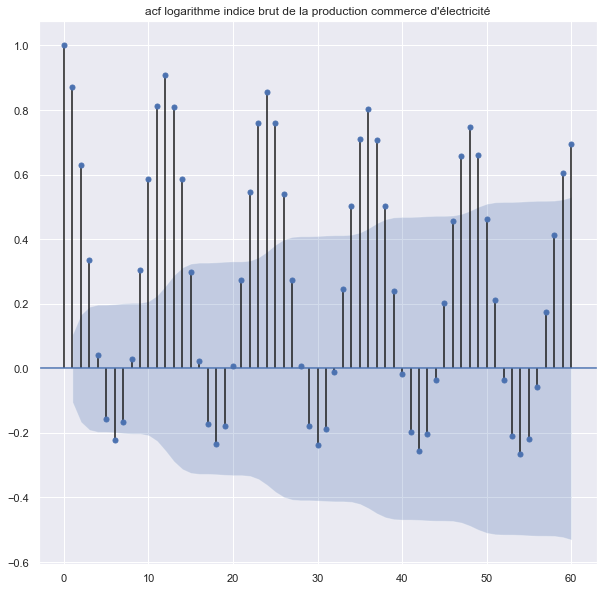

In [11]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    plot_acf(log_dfE, lags=60,
             title=u"acf logarithme indice brut de la production commerce d'électricité",
        )
#vrais intervalles de confiance : bartlet's formula

**Commentaires:** On observe une saisonalité annuelle (pic tous les 12 mois). Mais pas que tous les 12 mois les mois autours sont aussi fortement correlés (corrélation trimestrielle).

## PACF

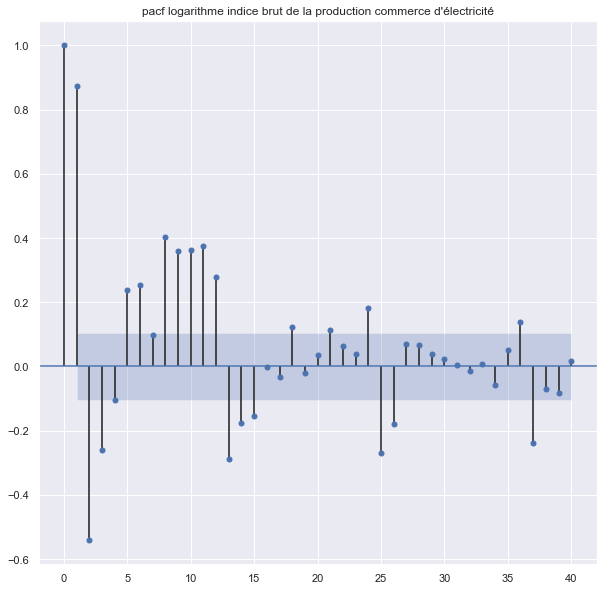

In [12]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    plot_pacf(log_dfE, lags=40,
             title=u"pacf logarithme indice brut de la production commerce d'électricité",
        )
#intervals de confiance standards pour un bruit blanc (+- 1.96/sqrt(n))

**Commentaires:** soupcon de racine unitaire, corrélation forte entre $X_t$ et $X_{t-1}$ (0.9).

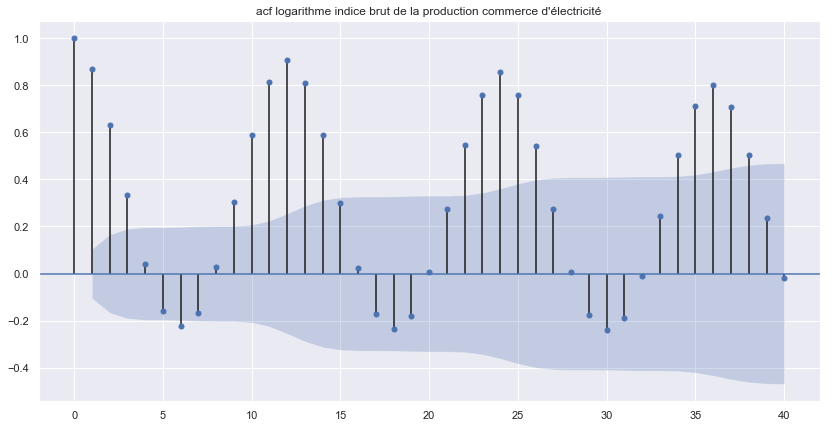

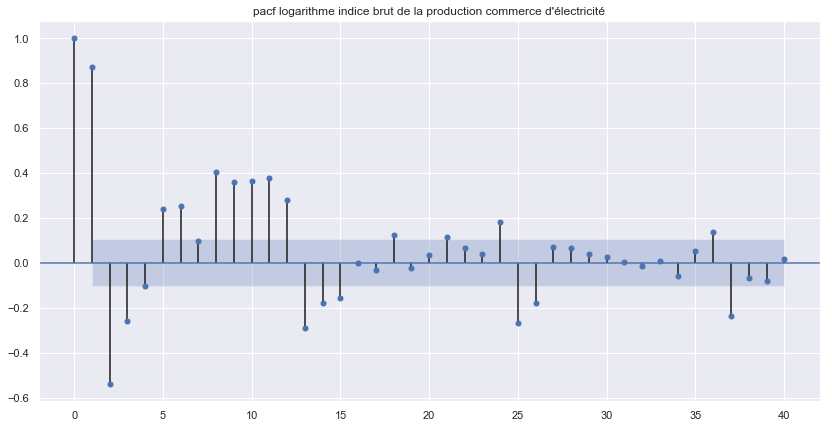

In [13]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(log_dfE, lags=40,
             title=u"acf logarithme indice brut de la production commerce d'électricité")
    plt.savefig("Images/acf.png")

    plot_pacf(log_dfE, lags=40,
             title=u"pacf logarithme indice brut de la production commerce d'électricité")
    plt.savefig("Images/pacf.png")

## Désaisonnalisation 

### Première méthode : différence 12ème 

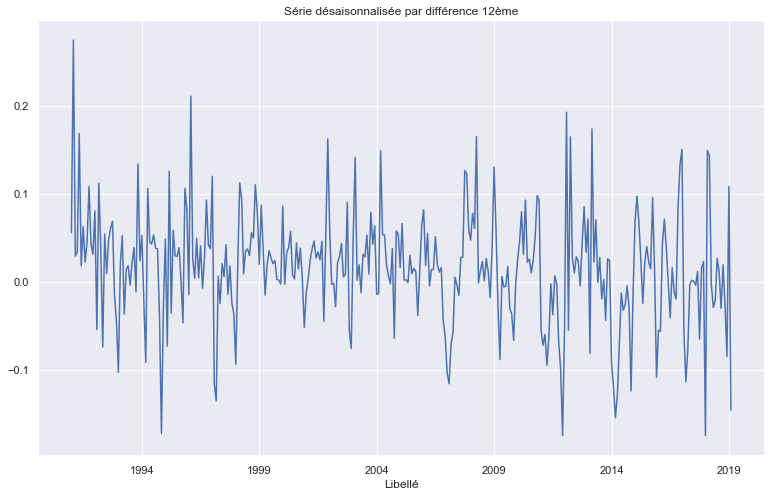

338

In [6]:
log_dfE_diff=log_dfE.diff(12).dropna()

log_dfE_diff.plot(title=u"Série désaisonnalisée par différence 12ème", legend=False, figsize=(13,8))

plt.savefig("Images/DeSaison.png")

plt.show()

len(log_dfE_diff) #on perd 12 observations

### 2ème méthode : régression avec des "dummy"

In [8]:
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
log_dfE.shape

(350, 1)

On régresse log_dfE sur les indicatrices de chaque mois : $$\log{\text{dfE}_t} = \alpha + \sum_{i=1}^{11} \beta_i \mathcal{1}_{\text{mois}_t=i} + \epsilon_t$$ $$Y = X'\beta + \epsilon$$ 

$X$ spécifier (350*12) par la cellule suivante, on ne prend que les indicatrices des 11 premiers mois pour éviter le DV trap.

In [9]:
# construction de la matrice X
X = np.tile(np.eye(12), 32).T[:350,:11]
X = sm.add_constant(X)
X = pd.DataFrame(X,index=log_dfE.index)
print(X.shape)
X.iloc[:13,:]

(350, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
Libellé,,,,,,,,,,,,
1990-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02-01,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03-01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05-01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-06-01,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1990-07-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1990-08-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1990-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
# On fait une régression par MCO du log du commerce d'électricité sur les dummy de mois (sauf 1 pour eviter le DV trap)
model = sm.OLS(log_dfE,X) 
results = model.fit()
DeSaison = results.resid # On récupère les résidus

In [11]:
#Voir comment récupérer ça pour le latex
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Electricite   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     49.26
Date:                Mon, 13 May 2019   Prob (F-statistic):           1.50e-63
Time:                        01:03:42   Log-Likelihood:                 165.28
No. Observations:                 350   AIC:                            -306.6
Df Residuals:                     338   BIC:                            -260.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              4.7315      0.029    165.939      0.0

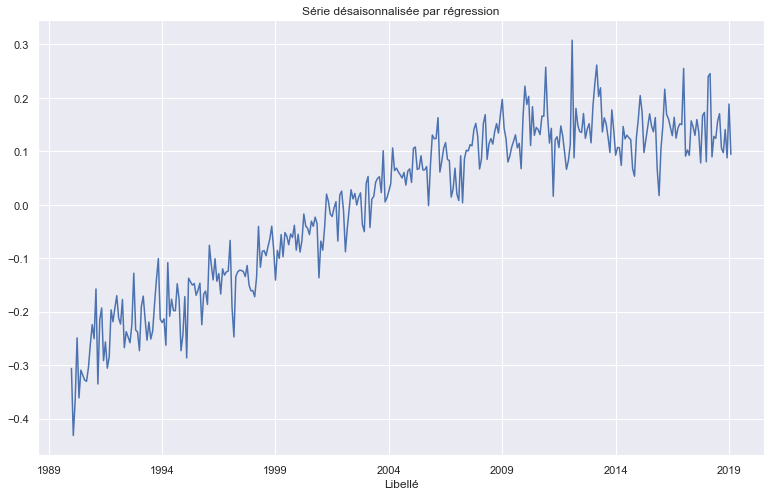

In [12]:
DeSaison.plot(title=u"Série désaisonnalisée par régression", legend=False,figsize=(13,8)) # Reste la tendance

plt.savefig("Images/DeSaison_reg.png")

plt.show()

## Differenciation à l'ordre 1 pour stationnariser

###  1ere methode

In [13]:
station = log_dfE_diff.diff(1).dropna()
len(station) #on perd encore une valeur

337

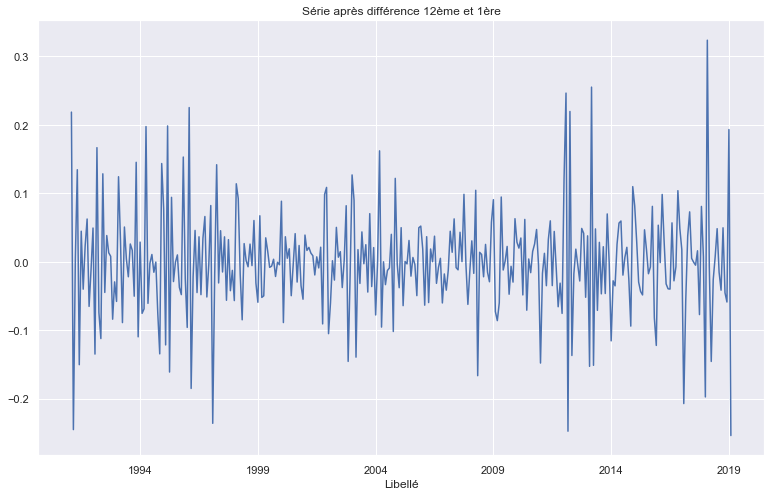

In [14]:
station.plot(title=u"Série après différence 12ème et 1ère", figsize=(13,8), legend=False)
plt.savefig("Images/DeSaison2.png")
plt.show()

Semble stationnaire. À confirmer avec des tests (plus loin dans le notebook).

### 2eme methode

On rajoute la différence première pour la suppression de la tendance.

In [15]:
station2 = DeSaison.diff(1).dropna()
len(station2) #la regression ne fait pas perder de valeur on aura donc perdu une seule valeur.

349

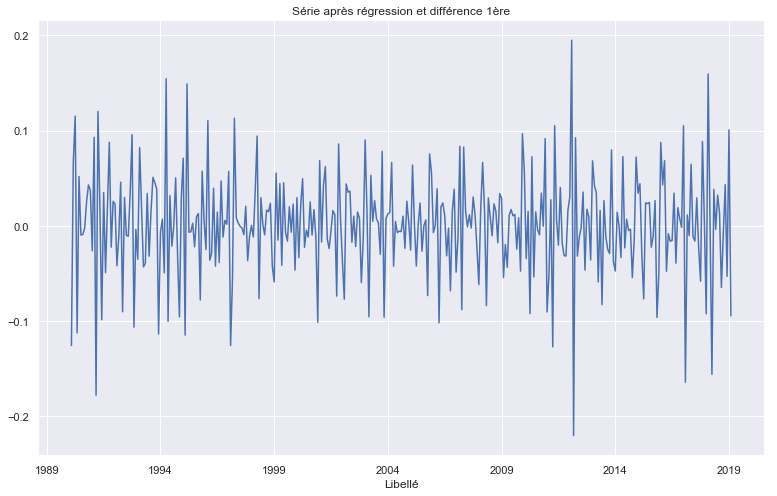

In [16]:
station2.plot(title=u"Série après régression et différence 1ère", figsize=(13,8))
plt.savefig("Images/DeSaison_reg_diff.png")
plt.show()

Semble stationnaire. À confirmer avec des tests (plus loin dans le notebook).

## ACF et PACF

### Difference 12eme 

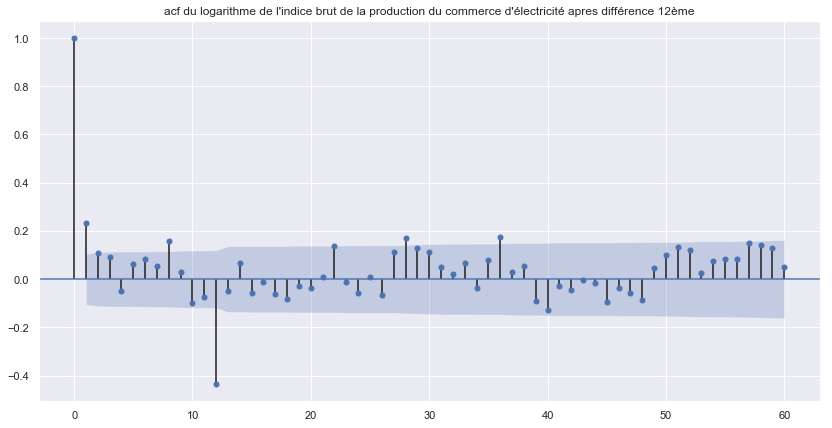

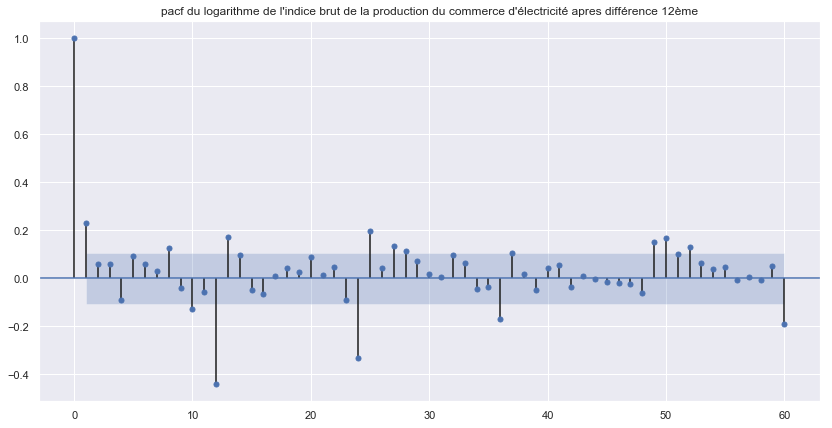

In [25]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(log_dfE_diff.values, lags=60,
             title=u"acf du logarithme de l'indice brut de la production du commerce d'électricité apres différence 12ème")
    plt.savefig("Images/acf12eme.png")

    plot_pacf(log_dfE_diff.values, lags=60,
           title=u"pacf du logarithme de l'indice brut de la production du commerce d'électricité apres différence 12ème")
    plt.savefig("Images/pacf12eme.png")

La désaisonnalisation avec différence 12ème ne semble pas avoir été efficace, on observe encore de fortes corrélations aux ordre 12,24,36.

### Difference 12eme et 1ere

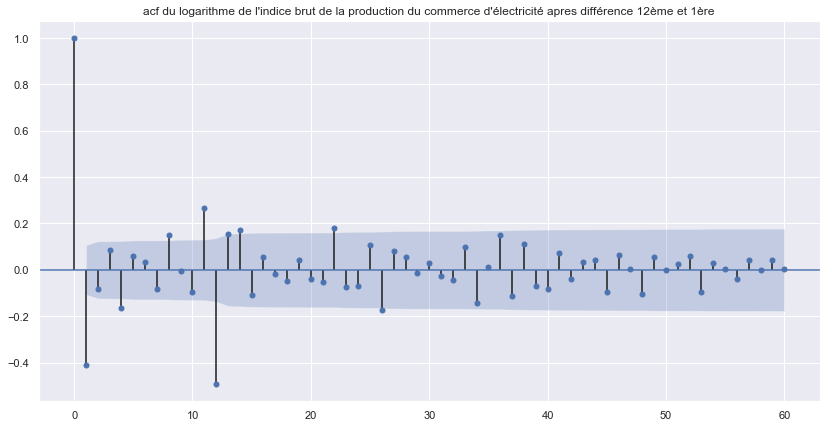

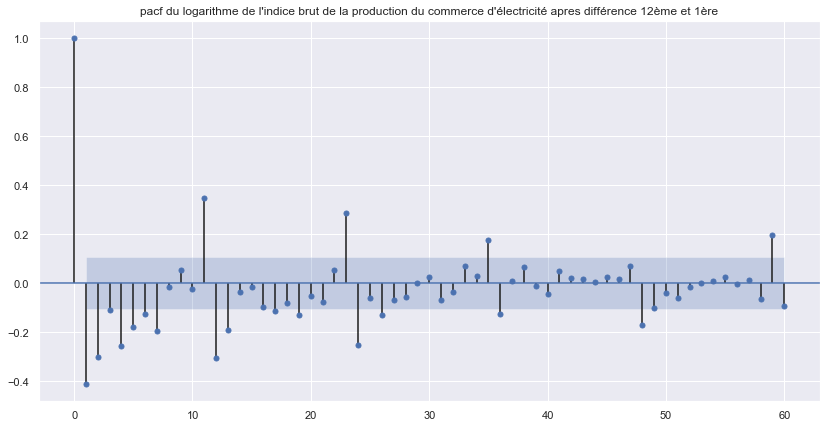

In [26]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(station.values, lags=60,
             title=u"acf du logarithme de l'indice brut de la production du commerce d'électricité apres différence 12ème et 1ère")
    plt.savefig("Images/acf12eme1ere.png")

    plot_pacf(station.values, lags=60,
        title=u"pacf du logarithme de l'indice brut de la production du commerce d'électricité apres différence 12ème et 1ère")
    plt.savefig("Images/pacf12eme1ere.png")

Le problème persiste, on va donc probablement préférer la seconde méthode.

### Regression

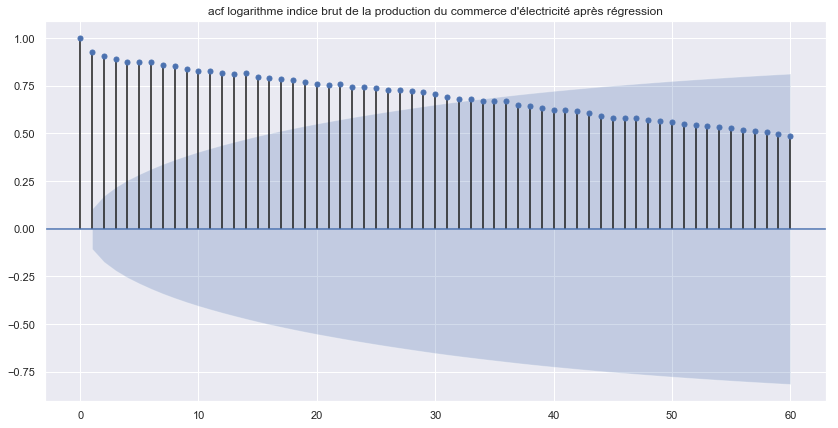

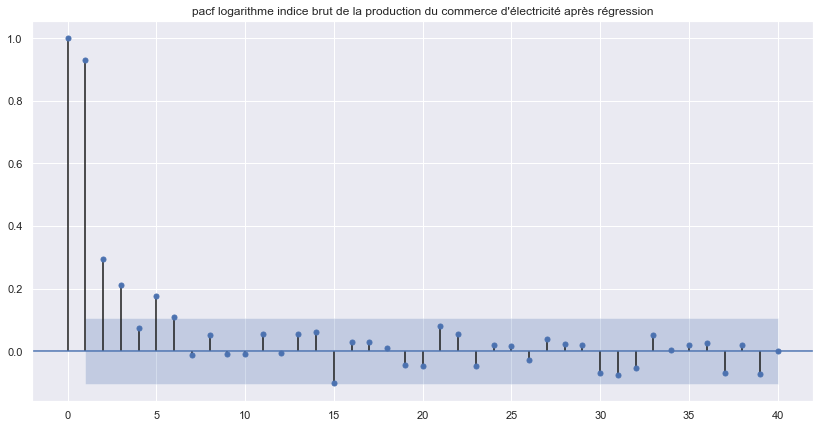

In [68]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(DeSaison.values, lags=60, title=u"acf logarithme indice brut de la production du commerce d'électricité après régression")
    plt.savefig("Images/acf_reg.png")

    plot_pacf(DeSaison.values, lags=40, title=u"pacf logarithme indice brut de la production du commerce d'électricité après régression")
    plt.savefig("Images/pacf_reg.png")

### Regression et difference 1ere

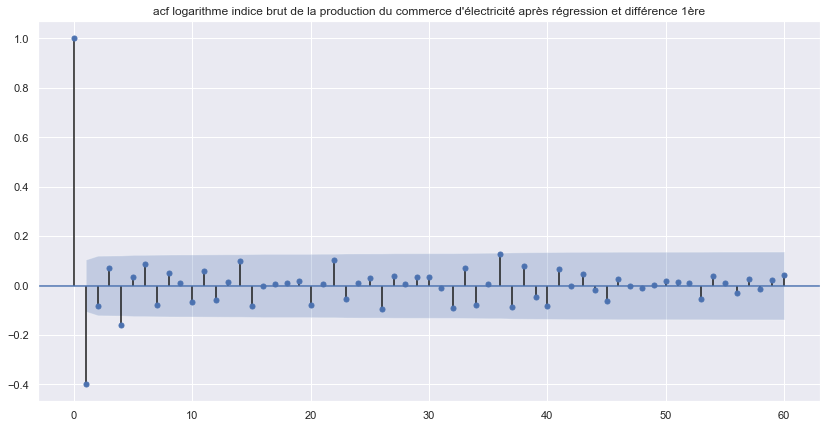

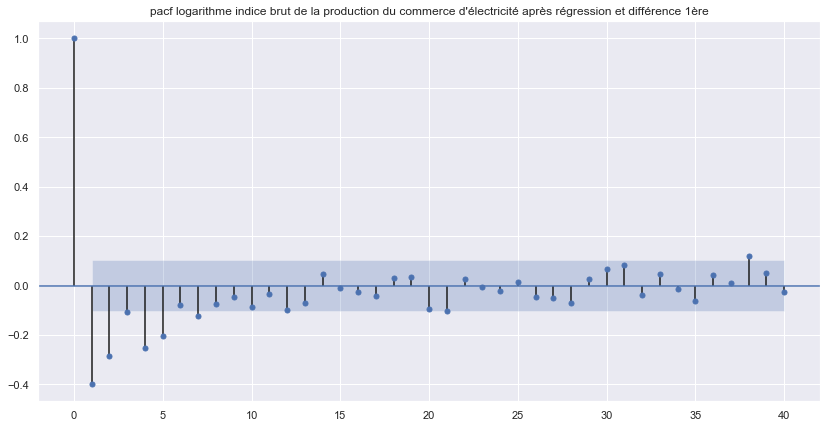

In [66]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(station2.values, lags=60, title=u"acf logarithme indice brut de la production du commerce d'électricité après régression et différence 1ère")
    plt.savefig("Images/acf_reg1ere.png")

    plot_pacf(station2.values, lags=40, title=u"pacf logarithme indice brut de la production du commerce d'électricité après régression et différence 1ère")
    plt.savefig("Images/pacf_reg1ere.png")

Bien plus satisfaisant, on garde cette méthode.

## Test de racine unitaire

Valider nos transformations de données et vérifier la stationnarité. Permet notamment de justifier que la méthode de désaisonnalisation avec régression est plus concluante. 

### ADF

** Série logarithmique **

In [21]:
from arch.unitroot import ADF
from statsmodels.stats.diagnostic import acorr_ljungbox

In [103]:
# Fonction qui retourne le nombre de lag adéquat et la table de régression pour le test ADF

def lag(data,spec):
    i=1
    adf = ADF(data,lags=i,trend=spec)
    ljung_box = np.min(acorr_ljungbox(adf.regression.resid)[1])
    while ljung_box < 0.05:
        i+=1
        adf = ADF(data,lags=i,trend=spec)
        ljung_box = np.min(acorr_ljungbox(adf.regression.resid)[1])
    return(i,adf.regression.summary())

In [105]:
adf = ADF(log_dfE,lags=lag(log_dfE,'ctt')[0],trend="ctt")

In [106]:
#pour le latex
dfadf = pd.DataFrame({"ADF Test":[adf.critical_values['1%'],adf.stat,adf.pvalue,adf.trend,adf.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","spécification","lags"])
dfadf
print(dfadf.to_latex())

\begin{tabular}{ll}
\toprule
{} &  ADF Test \\
\midrule
critical value (1\%) &  -4.40702 \\
Test Statistic      &  -2.09525 \\
p value             &  0.777915 \\
spécification       &       ctt \\
lags                &        23 \\
\bottomrule
\end{tabular}



** Différence 12ème**

In [109]:
adf = ADF(log_dfE_diff,lags=lag(log_dfE_diff,'ct')[0],trend="ct")

In [108]:
#pour le latex
dfadf = pd.DataFrame({"ADF Test":[adf.critical_values['1%'],adf.stat,adf.pvalue,adf.trend,adf.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","spécification","lags"])
dfadf
print(dfadf.to_latex())

\begin{tabular}{ll}
\toprule
{} &     ADF Test \\
\midrule
critical value (1\%) &     -3.98789 \\
Test Statistic      &     -6.75806 \\
p value             &  4.94579e-08 \\
spécification       &           ct \\
lags                &           23 \\
\bottomrule
\end{tabular}



**Différence 12ème et 1ère**

In [110]:
adf = ADF(station,lags=lag(station,'nc')[0],trend="nc")

In [111]:
#pour le latex
dfadf = pd.DataFrame({"ADF Test":[adf.critical_values['1%'],adf.stat,adf.pvalue,adf.trend,adf.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","spécification","lags"])
dfadf
print(dfadf.to_latex())

\begin{tabular}{ll}
\toprule
{} &     ADF Test \\
\midrule
critical value (1\%) &     -2.57292 \\
Test Statistic      &     -6.21694 \\
p value             &  3.21934e-09 \\
spécification       &           nc \\
lags                &           23 \\
\bottomrule
\end{tabular}



**Régression**

In [112]:
adf = ADF(DeSaison,lags=lag(DeSaison,'ct')[0],trend="ct")

In [113]:
#pour le latex
dfadf = pd.DataFrame({"ADF Test":[adf.critical_values['1%'],adf.stat,adf.pvalue,adf.trend,adf.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","spécification","lags"])
dfadf
print(dfadf.to_latex())

\begin{tabular}{ll}
\toprule
{} &   ADF Test \\
\midrule
critical value (1\%) &   -3.98525 \\
Test Statistic      &   -3.50644 \\
p value             &  0.0387066 \\
spécification       &         ct \\
lags                &          4 \\
\bottomrule
\end{tabular}



**Régression et différence 1ère**

In [114]:
adf = ADF(station2,lags=lag(station2,'nc')[0],trend="nc")

In [115]:
#pour le latex
dfadf = pd.DataFrame({"ADF Test":[adf.critical_values['1%'],adf.stat,adf.pvalue,adf.trend,adf.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","spécification","lags"])
dfadf
print(dfadf.to_latex())

\begin{tabular}{ll}
\toprule
{} &     ADF Test \\
\midrule
critical value (1\%) &     -2.57227 \\
Test Statistic      &     -14.3305 \\
p value             &  9.00539e-26 \\
spécification       &           nc \\
lags                &            4 \\
\bottomrule
\end{tabular}



### PP

In [47]:
from arch.unitroot import PhillipsPerron

#### Série logarithmique 

In [57]:
#série juste passer au log 
pp = PhillipsPerron(log_dfE.values)
pp.summary()

Test Statistic,-4.687
P-value,0.000
Lags,17


In [52]:
#pour le latex
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue,pp.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"])
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &    PP Test \\
\midrule
critical value (1\%) &  -3.449227 \\
Test Statistic      &  -4.687125 \\
p value             &   0.000089 \\
lags                &  17.000000 \\
\bottomrule
\end{tabular}



#### Différence 12ème

In [54]:
#log + difference 12
pp = PhillipsPerron(log_dfE_diff.values)
pp.summary()

Test Statistic,-14.404
P-value,0.000
Lags,17


In [55]:
#pour le latex
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue,pp.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"])
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &       PP Test \\
\midrule
critical value (1\%) & -3.449904e+00 \\
Test Statistic      & -1.440427e+01 \\
p value             &  8.408346e-27 \\
lags                &  1.700000e+01 \\
\bottomrule
\end{tabular}



#### Différence 12ème et 1ère

In [56]:
pp = PhillipsPerron(station)
pp.summary()

Test Statistic,-52.765
P-value,0.000
Lags,17


In [57]:
#pour le latex
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue,pp.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"])
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &    PP Test \\
\midrule
critical value (1\%) &  -3.449963 \\
Test Statistic      & -52.765237 \\
p value             &   0.000000 \\
lags                &  17.000000 \\
\bottomrule
\end{tabular}



#### Régréssion

In [58]:
pp = PhillipsPerron(DeSaison)
pp.summary()

Test Statistic,-3.039
P-value,0.031
Lags,17


In [59]:
#pour le latex
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue,pp.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"])
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &    PP Test \\
\midrule
critical value (1\%) &  -3.449227 \\
Test Statistic      &  -3.038621 \\
p value             &   0.031442 \\
lags                &  17.000000 \\
\bottomrule
\end{tabular}



#### Régréssion et différence 1ère

In [60]:
pp = PhillipsPerron(station2)
pp.summary()

Test Statistic,-53.422
P-value,0.000
Lags,17


In [61]:
#pour le latex
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue,pp.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"])
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &    PP Test \\
\midrule
critical value (1\%) &  -3.449282 \\
Test Statistic      & -53.422483 \\
p value             &   0.000000 \\
lags                &  17.000000 \\
\bottomrule
\end{tabular}



### Test de stationnarité : KPSS

In [116]:
from arch.unitroot import KPSS

#### Série logarithmique 

In [120]:
kpss = KPSS(log_dfE,lags=lag(log_dfE,"ctt")[0],trend="ct")
kpss.summary() #rejeté, on s'y attendait 

Test Statistic,0.350
P-value,0.001
Lags,23


In [121]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue,kpss.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &   0.217500 \\
Test Statistic      &   0.350060 \\
p value             &   0.000553 \\
lags                &  23.000000 \\
\bottomrule
\end{tabular}



#### Différence 12ème

In [124]:
kpss = KPSS(log_dfE_diff,lags=lag(log_dfE_diff,"ct")[0],trend="ct")
kpss.summary() #stationnaire autour d'un trend

Test Statistic,0.053
P-value,0.537
Lags,23


In [126]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue,kpss.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &   0.217500 \\
Test Statistic      &   0.052776 \\
p value             &   0.536694 \\
lags                &  23.000000 \\
\bottomrule
\end{tabular}



#### Différence 12ème et 1ère

In [129]:
kpss = KPSS(station,lags=lag(station,"nc")[0],trend="c")
kpss.summary() 

Test Statistic,0.073
P-value,0.733
Lags,23


In [130]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue,kpss.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &   0.742800 \\
Test Statistic      &   0.073124 \\
p value             &   0.733220 \\
lags                &  23.000000 \\
\bottomrule
\end{tabular}



#### Régréssion

In [133]:
kpss = KPSS(DeSaison,lags=lag(DeSaison,"ct")[0],trend="ct")
kpss.summary() 

Test Statistic,1.304
P-value,0.000
Lags,4


In [134]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue,kpss.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &   0.217500 \\
Test Statistic      &   1.303597 \\
p value             &   0.000100 \\
lags                &   4.000000 \\
\bottomrule
\end{tabular}



#### Régréssion et différence 1ère

In [135]:
kpss = KPSS(station2,lags=lag(station2,"nc")[0],trend="c")
kpss.summary() 

Test Statistic,0.059
P-value,0.821
Lags,4


In [136]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue,kpss.lags]},
             index = ["critical value (1%)","Test Statistic", "p value","lags"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &    0.74280 \\
Test Statistic      &    0.05890 \\
p value             &    0.82145 \\
lags                &    4.00000 \\
\bottomrule
\end{tabular}



## Conclusion

On garde "station2" : régression + difference 1ere qui passe les tests de stationnarité et de racine unitaire.
"station" passe aussi les tests mais on ne la garde pas, les acf et pacf sont moins concluants.

In [42]:
import os

In [43]:
station2.to_csv("Electricite/stationnaire.csv")

In [74]:
kpss = KPSS(station2)
pp = PhillipsPerron(station2)
dftests = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue],
                       "PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue]},
             index = ["critical value (1%)","Test Statistic", "p value"] )
dftests
print(dftests.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  KPSS Test &    PP Test \\
\midrule
critical value (1\%) &   0.742800 &  -3.449282 \\
Test Statistic      &   0.190010 & -53.422483 \\
p value             &   0.288276 &   0.000000 \\
\bottomrule
\end{tabular}



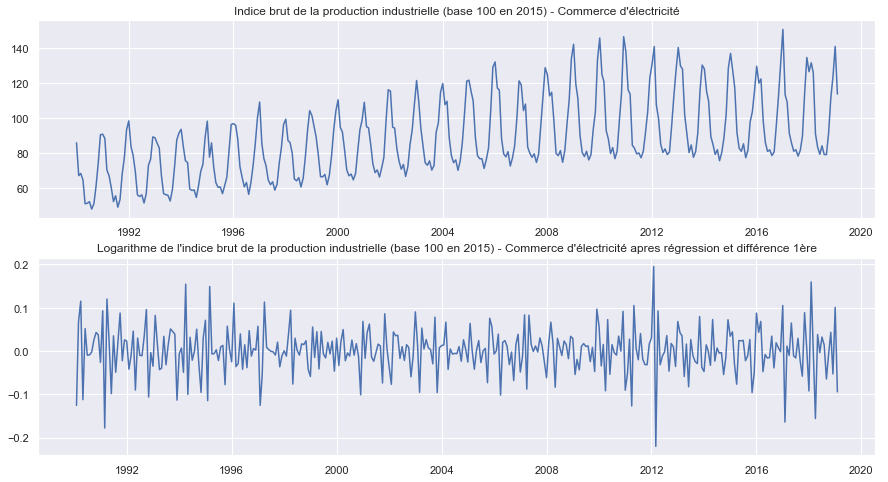

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(2, 1, 1)
plt.plot(dfE)
plt.title(u"Indice brut de la production industrielle (base 100 en 2015) - Commerce d'électricité")

plt.subplot(2, 1, 2)
plt.plot(station2)
plt.title(u"Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Commerce d'électricité apres régression et différence 1ère")

plt.savefig("reprgraphique.png")

plt.show()